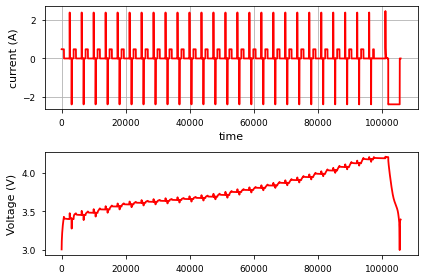

SolverError: Solution time vector has length 1. Check whether simulation terminated too early.

In [55]:
import pybamm
import numpy as np
import pandas as pd    # needed to read the csv data file
import matplotlib.pyplot as plt

# Import drive cycle from file
drive_cycle = pd.read_csv("output.csv", comment="#", header=None).to_numpy()


fig, axs = plt.subplots(2, 1)
axs[0].plot(drive_cycle[:, 0], drive_cycle[:, 1])
#axs[0].set_xlim(0, 2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('current (A)')
axs[0].grid(True)

axs[1].plot(drive_cycle[:, 0], drive_cycle[:, 2])
#cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
axs[1].set_ylabel('Voltage (V)')

fig.tight_layout()
plt.show()


model = pybamm.lithium_ion.SPMe()
#model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

# Create interpolant
timescale = parameter_values.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], -drive_cycle[:, 1], timescale * pybamm.t,interpolator="linear")


# c_n_init = self.parameter_values[
#     "Initial concentration in negative electrode [mol.m-3]"
# ]
# c_p_init = self.parameter_values[
#     "Initial concentration in positive electrode [mol.m-3]"
# ]
# param = pybamm.LithiumIonParameters()
# c_n_max = self.parameter_values.evaluate(param.c_n_max)
# c_p_max = self.parameter_values.evaluate(param.c_p_max)
# x, y = pybamm.lithium_ion.get_initial_stoichiometries(
#     initial_soc, self.parameter_values
# )
# self.parameter_values.update(
#     {
#         "Initial concentration in negative electrode [mol.m-3]": x
#         * c_n_max,
#         "Initial concentration in positive electrode [mol.m-3]": y
#         * c_p_max,
#     }
# )
initial_soc=0.5
c_n_init = parameter_values[
    "Initial concentration in negative electrode [mol.m-3]"
]
c_p_init = parameter_values[
    "Initial concentration in positive electrode [mol.m-3]"
]
param = pybamm.LithiumIonParameters()
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

x, y = pybamm.lithium_ion.get_initial_stoichiometries(
    initial_soc, parameter_values
)



# Set drive cycle
#parameter_values["Current function [A]"] = 10#;current_interpolant
parameter_values["Lower voltage cut-off [V]"] = 2.6
parameter_values["Upper voltage cut-off [V]"] = 4.2

# load solvers
safe_solver = pybamm.CasadiSolver(atol=1e-7, rtol=1e-9, mode="safe",dt_max=1e-6)
#scikits_solver=pybamm.ScikitsOdeSolver(method='cvode',atol=1e-6, rtol=1e-9,extrap_tol=0.001)
#model.set_soc_variables(),solver=safe_solver
sim = pybamm.Simulation(model, parameter_values=parameter_values)
#sim.solve(t_eval=drive_cycle[:, 0])
sim.solve([0, 1000])
sim.plot(["Current [A]", "Terminal voltage [V]"])
